# The Problem
From FiveThirtyEight, a problem is presented:

"*Two players go on a hot new game show called “Higher Number Wins.” The two go into separate booths, and each presses a button, and a random number between zero and one appears on a screen. (At this point, neither knows the other’s number, but they do know the numbers are chosen from a standard uniform distribution.) They can choose to keep that first number, or to press the button again to discard the first number and get a second random number, which they must keep. Then, they come out of their booths and see the final number for each player on the wall. The lavish grand prize — a case full of gold bullion — is awarded to the player who kept the higher number. Which number is the optimal cutoff for players to discard their first number and choose another? Put another way, within which range should they choose to keep the first number, and within which range should they reject it and try their luck with a second number?*" -- <cite>http://fivethirtyeight.com/features/can-you-win-this-hot-new-game-show/</cite>


# Hypothesis
My intuition was that the number should be about .5, based on the following:
1. The results of setting the cutoff at 0.0 and 1.0 are effectively the same
  * They're both just a random chance, 0.0 always taking the first, 1.0 always taking the second
2. It seems like .5, being the middle of the range, would yield the maximum expected value

# Testing the simple case
First, lets validate we know how to generate a random number

In [23]:
import random
num = random.random()
print num

0.384836990507


Now lets build a function that takes a threshold, and if the first generation is less than that threshold, tries another

In [24]:
def pickNumbers(cutoff):
    picks = [-1.0,-1.0]
    picks[0] = random.random()

    # If the first pick wasn't good enough, pick a new one
    if picks[0] < cutoff:
        picks[1] = random.random()
    # Otherwise, just keep the first pick
    else:
        picks[1] = picks[0]
    return picks

In [28]:
pickNumbers(.5)

[0.5234439937899515, 0.5234439937899515]

Now we need to run a simulation to test a sample cutoff, to determine what the typical value it determines

In [29]:
import graphlab
def runSimulation(numSim,cutoff,function=pickNumbers):
    picks0 = []
    picks1 = []
    cutoffs = [cutoff]*numSim
    
    # Run the simulation
    for i in range(0,numSim):
        pick = function(cutoff)
        picks0.append(pick[0])
        picks1.append(pick[1])

    #print picks
    #print len(picks0), len(picks1),len(cutoffs)
    
    return graphlab.SFrame({'cutoff':cutoffs,'pick0':picks0, 'pick1':picks1})
        

In [32]:
dataset = graphlab.SFrame()
dataset=dataset.append(runSimulation(1000,.5))

Now we have a simple simulation, lets take a look at some descriptive stats

In [35]:
graphlab.canvas.set_target('ipynb')
dataset.show(view="Summary")

These results confirm our expectations.

* The first pick looks normally distributed around .5
* Leveraging the cutoff of .5, the second pick (or keeping the first pick) gives better expected value

In [38]:
import graphlab.aggregate as agg
dataset.groupby(key_columns='cutoff',
               operations={"numSim":agg.COUNT(),
                          "pick0_mean":agg.MEAN('pick0'),
                          "pick1_mean":agg.MEAN('pick1'),
                          "pick0_median":agg.QUANTILE('pick0',0.5),
                          "pick1_median":agg.QUANTILE('pick1',0.5)})

cutoff,pick1_median,pick0_median,numSim,pick0_mean,pick1_mean
0.5,[0.647639614577],[0.502318638399],1000,0.491993974561,0.60645931579


# Lets try a few different options
We've confirmed the results for a cutoff of .5 about make sense.  Now lets look at all combos at .01 intervals

In [82]:
import numpy as np
large_dataset = graphlab.SFrame()
for cutoff in np.arange(0,1,.01):
    large_dataset=large_dataset.append(runSimulation(100000,cutoff))

In [83]:
large_dataset.show()

In [84]:
large_dataset.groupby(key_columns='cutoff',
               operations={"mean_pick":agg.MEAN('pick1'),
                          "stdDev":agg.STD('pick1'),
                          "25th":agg.QUANTILE('pick1',0.25),
                          "median":agg.QUANTILE('pick1',0.5)}).sort('mean_pick',ascending=False).print_rows(num_rows=20)

+--------+----------------+------------------+------------------+----------------+
| cutoff |   mean_pick    |       25th       |      median      |     stdDev     |
+--------+----------------+------------------+------------------+----------------+
|  0.49  | 0.626080698081 | [0.497375094565] | [0.665976548345] | 0.258586154582 |
|  0.53  | 0.625650306544 | [0.474778176738] | [0.674137265897] | 0.264944562628 |
|  0.48  | 0.62563614328  | [0.494627001739] | [0.66365669379]  | 0.257357239571 |
|  0.5   | 0.625578014278 | [0.50069416512]  | [0.667738909433] | 0.259779717843 |
|  0.55  | 0.625493964752 | [0.456433090522] | [0.679005455177] | 0.268955684605 |
|  0.47  | 0.624886739076 | [0.490344245678] | [0.660226124937] | 0.255062192348 |
|  0.51  | 0.624743327744 | [0.487359665595] | [0.669070461397] | 0.261352401471 |
|  0.52  | 0.624727891394 | [0.479121688422] | [0.672347844839] | 0.263128062439 |
|  0.46  | 0.624196368285 | [0.486912372111] | [0.658078616663] | 0.254136770527 |
|  0

Here is a distribution of the first pick.  It looks randomly distributed, as expected.

In [85]:
large_dataset.show(view="Scatter Plot",x='cutoff',y='pick0')

And here's the distribution of the second pick, which we hope to be better

In [86]:
large_dataset.show(view="Scatter Plot",x='cutoff',y='pick1')

In [101]:
large_dataset.show(view='BoxWhisker Plot',x='cutoff',y='pick1')

<img src="boxwhisker_cutoff_pick1.png">

# Some more visualization
Lets try some other visualization

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

# Generate some interesting stats
large_stats = large_dataset.groupby(key_columns='cutoff',
               operations={"mean":agg.MEAN('pick1'),
                          "25th":agg.QUANTILE('pick1',0.25),
                          "median":agg.QUANTILE('pick1',0.5)})

# Do some munging to get the median out of a list into a raw number column
large_stats = large_stats.unpack(unpack_column='median').rename({'median.0':'median'})
large_stats = large_stats.unpack(unpack_column='25th').rename({'25th.0':'25th'})


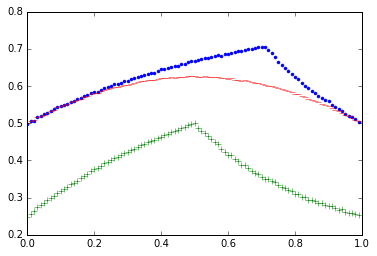

In [95]:
plt.plot(large_stats['cutoff'],large_stats['median'],".",
        large_stats['cutoff'],large_stats['25th'],"+",
        large_stats['cutoff'],large_stats['mean'],"_")

In [99]:
print large_stats.sort('median',ascending=False).print_rows(num_rows=5)

+--------+----------------+----------------+----------------+
| cutoff |      mean      |     median     |      25th      |
+--------+----------------+----------------+----------------+
|  0.7   | 0.604042775673 | 0.705922076213 | 0.354588068045 |
|  0.69  | 0.608244747519 | 0.704275677225 | 0.364318048421 |
|  0.71  | 0.601883171673 | 0.703910731538 | 0.349727154533 |
|  0.68  | 0.60761255509  | 0.702716172867 | 0.364990460873 |
|  0.67  | 0.610174233888 | 0.700801691593 | 0.372403197275 |
+--------+----------------+----------------+----------------+
[100 rows x 4 columns]

None


In [100]:
print large_stats.sort('25th',ascending=False).print_rows(num_rows=5)

+--------+----------------+----------------+----------------+
| cutoff |      mean      |     median     |      25th      |
+--------+----------------+----------------+----------------+
|  0.5   | 0.625578014278 | 0.667738909433 | 0.50069416512  |
|  0.49  | 0.626080698081 | 0.665976548345 | 0.497375094565 |
|  0.48  | 0.62563614328  | 0.66365669379  | 0.494627001739 |
|  0.47  | 0.624886739076 | 0.660226124937 | 0.490344245678 |
|  0.51  | 0.624743327744 | 0.669070461397 | 0.487359665595 |
+--------+----------------+----------------+----------------+
[100 rows x 4 columns]

None


# Conclusion

It looks like there are a few maximums:
1. 25th Percentile and Mean (At .5)
2. Median (At .7)

If I was to play the game, I would set my cutoff at **0.7**


If you are having problems viwing the images in this Jupyter notebook (probably due to github's rendering of SFrame's), check out the PDF here: https://github.com/asealey/fivethirtyeight/blob/master/The%20Riddler%20-%20Gameshow.pdf

# Overkill...Simulating head to head
Lets take Luke (me) versus Vader (Competition)

In [167]:
cutoffs = {'luke':0.7,'vader':.65}

In [176]:
numSim = 100000
faceoff = graphlab.SFrame()
results = {}
for contestant in ['luke','vader']:
    results[contestant] = runSimulation(numSim,cutoffs[contestant])['pick1']
    
# Compile the results
faceoff = graphlab.SFrame(results)

# Calculate if Luke Won
results = faceoff.apply(lambda x: True if x['luke'] > x['vader'] else False)

# Calculate the win percentage
len(results[(results > 0)])*1.0 / len(results)

0.49276